WNixalo | 20181126;30

following: https://medium.com/@dariusl/getting-started-with-the-diux-xview-dataset-for-overhead-object-detection-84fc4d918d09

and [DIUx_xView/data_utilities/xView Processing.ipynb](https://github.com/DIUx-xView/data_utilities/blob/master/xView%20Processing.ipynb)

---

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import json
import csv

## 1. Data

In [2]:
path = Path().home()/'.fastai/data/xview'

In [3]:
list((Path().home()/'.fastai/data/xview').iterdir())

[PosixPath('/home/jupyter/.fastai/data/xview/val_images'),
 PosixPath('/home/jupyter/.fastai/data/xview/train_images'),
 PosixPath('/home/jupyter/.fastai/data/xview/val_images.tgz'),
 PosixPath('/home/jupyter/.fastai/data/xview/train_labels.tgz'),
 PosixPath('/home/jupyter/.fastai/data/xview/xView_train.geojson'),
 PosixPath('/home/jupyter/.fastai/data/xview/train_images.tgz')]

In [4]:
# ! tar -xzf {path}/train_labels.tgz -C {path}

In [5]:
# %time ! tar -xzf {path}/train_images.tgz -C {path}

In [6]:
# %time ! tar -xzf {path}/val_images.tgz -C {path}

## 2. Displaying Images

In [7]:
fname = 'chips/104.tif'
img = np.array(Image.open(path/'train_images/104.tif'))

In [1]:
# Image.open(path/'train_images/104.tif') # worked; but dont want a 15.6 MB img in git history

## 3. Ground Truth Labels

In [9]:
# Processes an xView GeoJSON file
# INPUT: filepath to the GeoJSON file
# OUTPUT: Bounding box coordinate array, Chip-name array, and Class-id array

def get_labels(fname='xView_train.geojson'):
    with open(fname) as f: data = json.load(f)
    # init to dataset shape
    coords = np.zeros((len(data['features']), 4))
    chips  = np.zeros((len(data['features'])), dtype='object')
    classes= np.zeros((len(data['features'])))
    
    for i in range(len(data['features'])):
        if data['features'][i]['properties']['bounds_imcoords'] != []:
            b_id = data['features'][i]['properties']['image_id']
            val  = np.array([int(num) for num in 
                             data['features'][i]['properties']['bounds_imcoords'].split(",")])
            chips[i] = b_id
            classes[i] = data['features'][i]['properties']['type_id']
            coords[i] = val
        else:
            chips[i] = 'None'
    
    return coords, chips, classes

note: coordinate format: (xmin,ymin,xmax,ymax)

## 4. Chipping Images and Relative Bounding Boxes

In [10]:
# ! git clone https://github.com/DIUx-xView/data_utilities.git

In [11]:
import sys
sys.path.append('data_utilities') # look in dir for finding modules

In [34]:
import wv_util as wv
import aug_util as aug

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now another way (probably the 'right' way) to load the image:

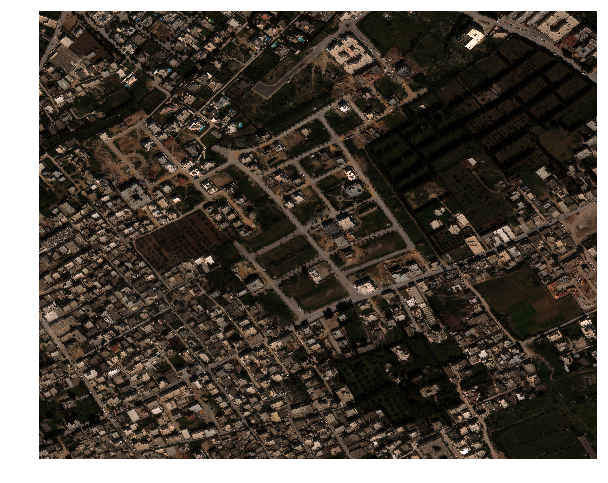

In [13]:
# Load an image
chip_name = '104.tif'
arr = wv.get_image(path/'train_images'/chip_name)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(arr);

In [14]:
??wv.get_labels

Signature: wv.get_labels(fname)
Source:   
def get_labels(fname):
    """
    Gets label data from a geojson label file

    Args:
        fname: file path to an xView geojson label file

    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
    with open(fname) as f:
        data = json.load(f)

    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))

    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bounds_imcoords'] != []:
            b_id = data['features'][i]['properties']['image_id']
            val = np.array([int(num) for num in data['features'][i]['properties']['bounds_imcoords'].split(",")])
            chips[i] = b_id
            classes[i] = data['features'][i]['properties']['type_id']
            if val.shape[0] !=

Cool, looks like the code block in the Medium post was writing the data utility function; but I guess the author got tired because he stopped with the code and examples after section 3 -- which is why I'm bringing the xview notebook.

In [15]:
# Loading labels
coords, chips, classes = wv.get_labels(path/'xView_train.geojson')
# We only want the coordinates and classes that are within our chip
coords = coords[chips==chip_name]
classes = classes[chips==chip_name].astype(np.int64)

100%|██████████| 601937/601937 [00:02<00:00, 267591.55it/s]


In [22]:
# Load the class number -> class string label map
labels = {}
with open('data_utilities/xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

In [19]:
# with open(path/'xView_train.geojson') as f: data = json.load(f)
# data.keys()
# data['features']

In [23]:
# We can find which classes are present in this image
print([labels[i] for i in np.unique(classes)])

['Small Car', 'Bus', 'Truck', 'Cargo Truck', 'Trailer', 'Scraper/Tractor', 'Shed', 'Building', 'Damaged Building']


In [25]:
# We can chip the image into 500x500 chips -- this is what im interested in
c_img, c_box, c_cls = wv.chip_image(img=arr, coords=coords, classes=classes,shape=(500,500))
print(f"Num Chips: {c_img.shape[0]}")

Num Chips: 30


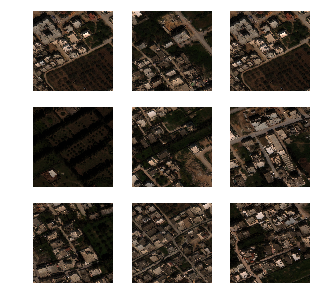

In [28]:
# We can plot some of the chips
fig,ax = plt.subplots(3)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(9):
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]),replace=False)])

plt.show()

In [30]:
c_img.shape # chip image, (num_chips, rows, cols, color channels)

(30, 500, 500, 3)

as usual, I had issues installing tensorflow (needed for the baseline; guess they're using it for inference) -- gpu vsn doesn't see CUDA 9.1, and goes "`ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory`"; but I won't be training with it; and thankfully the cpu vsn installed wo/ issue.

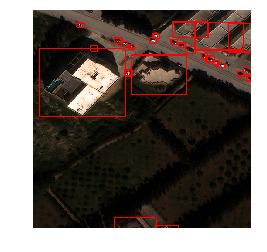

In [37]:
# We can visualize the chips with their labels
ind = np.random.choice(range(c_img.shape[0]))
labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
plt.axis('off')
plt.imshow(labelled);

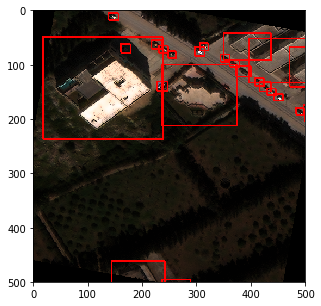

In [40]:
# We can rotate the chips
center = (int(c_img[ind].shape[0]/2), int(c_img[ind].shape[1]/2))
i2,b2  = aug.rotate_image_and_boxes(c_img[ind], 10, center, c_box[ind])
a2 = aug.draw_bboxes(i2,b2)
plt.figure(figsize=(5,5))
plt.axis=('off')
plt.imshow(a2);

In [ ]:
# There are other augmentations available in `aug_util.py`
# From here, you can save out the chipped images to a TFRecord or other medium
# User `process_wv.py` to create a TFRecord file from xView category

So my beginning thoughts are these:

1. chip the dataset; use the chipped dataset as input to the fastai-pytorch model.
    1. for picking chip-size: consider batch-size and field-of-view.
2. use fastai to do augmentation on the chipped dataset.
3. if necc: turn the chipper into an automated pre-processor so the model can work on any input image.

## 5. Saving to TFRecord Format

basically -- use what works. I'm not using tensorflow; so I'll be going JPG + CSV.

## Data Augmentation

They warn against doing augmentation per chip ... but fastai is specifically designed to do fast augmentation -- so we'll see.